### 这部分是生成训练与验证集的BEV数据的代码

### Outline

##### A. Creating an index and splitting into train and validation scenes
1. Loading the dataset
2. Creating a dataframe with one scene per row.
3. Splitting all data into a train and validation set by car

#### B. Creating input and targets
1. We produce top-down images and targets
2. Running this on all of the data in parallel

In [1]:
# Our code will generate data, visualization and model checkpoints, they will be persisted to disk in this folder
DATA_FOLDER = "/media/bob/data/lyft"
!ln -s /media/bob/data/lyft/train_images images
!ln -s /media/bob/data/lyft/train_maps maps
!ln -s /media/bob/data/lyft/train_lidar lidar

ln: failed to create symbolic link 'images/train_images': File exists
ln: failed to create symbolic link 'maps/train_maps': File exists
ln: failed to create symbolic link 'lidar/train_lidar': File exists


In [2]:
%load_ext autoreload

from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

## A. Creating an index and splitting into train and validation scenes

In [3]:
level5data = LyftDataset(data_path='.', json_path='/home/bob/data/lyft_data/train_data', verbose=True)
os.makedirs(ARTIFACTS_FOLDER, exist_ok=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 7.4 seconds.
Reverse indexing ...
Done reverse indexing in 3.1 seconds.


We create a Pandas DataFrame with a row for each of the scenes

In [4]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in
        level5data.scene]

entries = []

for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000

    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))
            
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [5]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64


### Train/Validation split
Let's split the data by car to get a validation set.
Alternatively we could consider doing it by scenes, date, or completely randomly.

In [6]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

In [7]:
len(train_df)

140

In [8]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

## B. Creating input and targets

Let's load the first sample in the train set. We can use that to test the functions we'll define next that transform the data to the format we want to input into the model we are training.

In [9]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"]) #pose of the car
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

# Homogeneous transformation matrix from car frame to world frame.
global_from_car = transform_matrix(ego_pose['translation'],
                                   Quaternion(ego_pose['rotation']), inverse=False)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
car_from_sensor = transform_matrix(calibrated_sensor['translation'], 
                                   Quaternion(calibrated_sensor['rotation']), inverse=False)

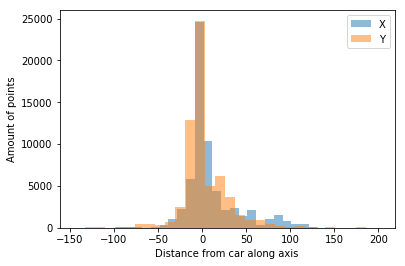

In [10]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)

# A sanity check, the points should be centered around 0 in car space.
plt.hist(lidar_pointcloud.points[0], alpha=0.5, bins=30, label="X")
plt.hist(lidar_pointcloud.points[1], alpha=0.5, bins=30, label="Y")
plt.legend()
plt.xlabel("Distance from car along axis")
plt.ylabel("Amount of points")
plt.show()

In [11]:
lidar_pointcloud.points.shape

(4, 61908)

In [12]:
map_mask = level5data.map[0]["mask"]

In [13]:
def get_semantic_map_around_ego(map_mask, ego_pose, voxel_size, output_shape):

    def crop_image(image: np.array,
                           x_px: int,
                           y_px: int,
                           axes_limit_px: int) -> np.array:
                x_min = int(x_px - axes_limit_px)
                x_max = int(x_px + axes_limit_px)
                y_min = int(y_px - axes_limit_px)
                y_max = int(y_px + axes_limit_px)

                cropped_image = image[y_min:y_max, x_min:x_max]

                return cropped_image

    pixel_coords = map_mask.to_pixel_coords(ego_pose['translation'][0], ego_pose['translation'][1])

    extent = voxel_size*output_shape[0]*0.5
    scaled_limit_px = int(extent * (1.0 / (map_mask.resolution)))
    mask_raster = map_mask.mask()

    cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * np.sqrt(2)))

    ypr_rad = Quaternion(ego_pose['rotation']).yaw_pitch_roll
    yaw_deg = -np.degrees(ypr_rad[0])

    rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))
    ego_centric_map = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2,
                                 scaled_limit_px)[::-1]
    
    ego_centric_map = cv2.resize(ego_centric_map, output_shape[:2], cv2.INTER_NEAREST)
    return ego_centric_map.astype(np.float32)/255

As input for our network we voxelize the LIDAR points. That means that we go from a list of coordinates of points, to a X by Y by Z space.

In [14]:
def create_transformation_matrix_to_voxel_space(shape, voxel_size, offset):
    """
    Constructs a transformation matrix given an output voxel shape such that (0,0,0) ends up in the center.
    Voxel_size defines how large every voxel is in world coordinate, (1,1,1) would be the same as Minecraft voxels.
    
    An offset per axis in world coordinates (metric) can be provided, this is useful for Z (up-down) in lidar points.
    No rotation, only a scale and translation.
    """
    
    shape, voxel_size, offset = np.array(shape), np.array(voxel_size), np.array(offset)
    
    tm = np.eye(4, dtype=np.float32) #(4,4)
    translation = shape/2 + offset/voxel_size #(3,)
    
    tm = tm * np.array(np.hstack((1/voxel_size, [1]))) # (4,4)

    tm[:3, 3] = np.transpose(translation)
    return tm

def transform_points(points, transf_matrix):
    """
    Transform (3,N) or (4,N) points using transformation matrix.
    """
    if points.shape[0] not in [3,4]:
        raise Exception("Points input should be (3,N) or (4,N) shape, received {}".format(points.shape))
    return transf_matrix.dot(np.vstack((points[:3, :], np.ones(points.shape[1]))))[:3, :]

In [15]:
def car_to_voxel_coords(points, shape, voxel_size, z_offset=0):
    if len(shape) != 3:
        raise Exception("Voxel volume shape should be 3 dimensions (x,y,z)")
        
    if len(points.shape) != 2 or points.shape[0] not in [3, 4]:
        raise Exception("Input points should be (3,N) or (4,N) in shape, found {}".format(points.shape))

    tm = create_transformation_matrix_to_voxel_space(shape, voxel_size, (0, 0, z_offset))
    p = transform_points(points, tm) #(3, N)
    return p

def create_voxel_pointcloud(points, shape, voxel_size=(0.5,0.5,1), z_offset=0):

    points_voxel_coords = car_to_voxel_coords(points.copy(), shape, voxel_size, z_offset) #(3,N)
    points_voxel_coords = points_voxel_coords[:3].transpose(1,0) #(N, 3)
    points_voxel_coords = np.int0(points_voxel_coords)
    
    bev = np.zeros(shape, dtype=np.float32)
    bev_shape = np.array(shape)

    within_bounds = (np.all(points_voxel_coords >= 0, axis=1) * np.all(points_voxel_coords < bev_shape, axis=1))
    
    points_voxel_coords = points_voxel_coords[within_bounds]
    coord, count = np.unique(points_voxel_coords, axis=0, return_counts=True)
        
    # Note X and Y are flipped:
    bev[coord[:,1], coord[:,0], coord[:,2]] = count
    
    return bev

def normalize_voxel_intensities(bev, max_intensity=16):
    return (bev/max_intensity).clip(0,1)

**why points.shape[0]=4?
最后一行是强度吗?**

Above is an example of what the input for our network will look like. It's a top-down projection of the world around the car (the car faces to the right in the image). The height of the lidar points are separated into three bins, which visualized like this these are the RGB channels of the image.

In [16]:
def move_boxes_to_car_space(boxes, ego_pose):
    """
    Move boxes from world space to car space.
    Note: mutates input boxes.
    """
    translation = -np.array(ego_pose['translation'])
    rotation = Quaternion(ego_pose['rotation']).inverse
    
    for box in boxes:
        # Bring box to car space
        box.translate(translation)
        box.rotate(rotation)
        
def scale_boxes(boxes, factor):
    """
    Note: mutates input boxes
    """
    for box in boxes:
        box.wlh = box.wlh * factor

def draw_boxes(im, voxel_size, boxes, classes, z_offset=0.0):
    for box in boxes:
        # We only care about the bottom corners
        corners = box.bottom_corners()
        corners_voxel = car_to_voxel_coords(corners, im.shape, voxel_size, z_offset).transpose(1,0)
        corners_voxel = corners_voxel[:,:2] # Drop z coord

        class_color = classes.index(box.name) + 1
        
        if class_color == 0:
            raise Exception("Unknown class: {}".format(box.name))

        cv2.drawContours(im, np.int0([corners_voxel]), 0, (class_color, class_color, class_color), -1)

These are the annotations in the same top-down frame, Below we plot the same scene using the NuScenes SDK. Don't worry about it being flipped.

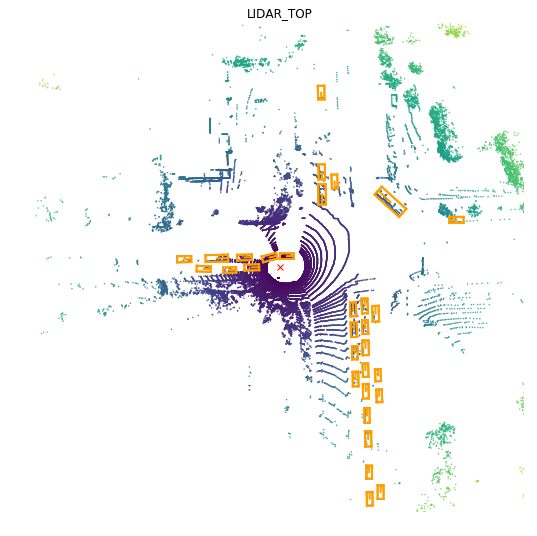

In [17]:
def visualize_lidar_of_sample(sample_token, axes_limit=80):
    sample = level5data.get("sample", sample_token)
    sample_lidar_token = sample["data"]["LIDAR_TOP"]
    level5data.render_sample_data(sample_lidar_token, axes_limit=axes_limit)
visualize_lidar_of_sample(sample_token)

跟上面生成的二值GT图像正好上下颠倒,这可能跟plt的画图方式有关

Now we will run this on all samples in the train and validation set, and write the input and target images to their respective folders.

### 通过更改以下参数来确定BEV的分辨率

In [18]:
# Some hyperparameters we'll need to define for the system
voxel_size = (0.3, 0.3, 1.0)
z_offset = -2.0
bev_shape = (496, 496, 3)
# We scale down each box so they are more separated when projected into our coarse voxel space.
box_scale = 0.9

In [19]:
# "bev" stands for birds eye view
train_data_folder = os.path.join(ARTIFACTS_FOLDER, "bev_train_data")
validation_data_folder = os.path.join(ARTIFACTS_FOLDER, "./bev_validation_data")

In [ ]:
NUM_WORKERS = os.cpu_count()

def prepare_training_data_for_scene(first_sample_token, output_folder, bev_shape, voxel_size, z_offset, box_scale):
    """
    Given a first sample token (in a scene), output rasterized input volumes and targets in birds-eye-view perspective.
    

    """
    sample_token = first_sample_token
    
    while sample_token:
        
        sample = level5data.get("sample", sample_token)

        sample_lidar_token = sample["data"]["LIDAR_TOP"]
        lidar_data = level5data.get("sample_data", sample_lidar_token)
        lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

        ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
        calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])


        global_from_car = transform_matrix(ego_pose['translation'],
                                           Quaternion(ego_pose['rotation']), inverse=False)

        car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),
                                            inverse=False)

        try:
            lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)
            lidar_pointcloud.transform(car_from_sensor)
        except Exception as e:
            print ("Failed to load Lidar Pointcloud for {}: {}:".format(sample_token, e))
            sample_token = sample["next"]
            continue
        
        bev = create_voxel_pointcloud(lidar_pointcloud.points, bev_shape, voxel_size=voxel_size, z_offset=z_offset)
        bev = normalize_voxel_intensities(bev)

        
        boxes = level5data.get_boxes(sample_lidar_token)

        target = np.zeros_like(bev)

        move_boxes_to_car_space(boxes, ego_pose)
        scale_boxes(boxes, box_scale)
        draw_boxes(target, voxel_size, boxes=boxes, classes=classes, z_offset=z_offset)

        bev_im = np.round(bev*255).astype(np.uint8)
        target_im = target[:,:,0] # take one channel only
        
        #semantic_im = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size[0], target_im.shape)
        #semantic_im = np.round(semantic_im*255).astype(np.uint8)

        cv2.imwrite(os.path.join(output_folder, "{}_input.png".format(sample_token)), bev_im)
        cv2.imwrite(os.path.join(output_folder, "{}_target.png".format(sample_token)), target_im)
        #cv2.imwrite(os.path.join(output_folder, "{}_map.png".format(sample_token)), semantic_im)
        
        sample_token = sample["next"]

for df, data_folder in [(train_df, train_data_folder), (validation_df, validation_data_folder)]:
    print("Preparing data into {} using {} workers".format(data_folder, NUM_WORKERS))
    first_samples = df.first_sample_token.values
    os.makedirs(data_folder, exist_ok=True)
    
    process_func = partial(prepare_training_data_for_scene,
                           output_folder=data_folder, bev_shape=bev_shape, voxel_size=voxel_size, z_offset=z_offset, box_scale=box_scale)

    pool = Pool(NUM_WORKERS)
    for _ in tqdm_notebook(pool.imap_unordered(process_func, first_samples), total=len(first_samples)):
        pass
    pool.close()